In [29]:
import pandas as pd
import numpy as np
import sidetable
import matplotlib.pyplot as plt
import seaborn as sns
# Establecer tamaño fijo de gráficas
plt.rcParams["figure.figsize"] = (10,8)

# Configuración warnings
import warnings
warnings.filterwarnings('ignore')

EJERCICIO 1: Buscar un conjunto de datos a analizar

In [30]:
df=pd.read_csv('../datos/ds_salaries.csv', index_col=0)
df.head(2) #Hacemos una vista previa de nuestro DataFrame

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2020,MI,FT,Data Scientist,70000,EUR,79833,DE,0,DE,L
1,2020,SE,FT,Machine Learning Scientist,260000,USD,260000,JP,0,JP,S


Explicar los datos y las variables disponibles en el conjunto de datos seleccionado:

| work_year| The year the salary was paid |
|----------|------------------------------|
| experience_level| The experience level in the job during the year with the following possible values: EN Entry-level / Junior MI Mid-level / Intermediate SE Senior-level / Expert EX Executive-level / Director|
| employment_type| The type of employement for the role: PT Part-time FT Full-time CT Contract FL Freelance|
| job_title| The role worked in during the year|
| salary| The total gross salary amount paid |
| salary_currency| The currency of the salary paid as an ISO 4217 currency code |
| salaryinusd| The salary in USD (FX rate divided by avg. USD rate for the respective year via fxdata.foorilla.com) |
| employee_residence| Employee's primary country of residence in during the work year as an ISO 3166 country code |
| remote_ratio| The overall amount of work done remotely, possible values are as follows: 0 No remote work (less than 20%) 50 Partially remote 100 Fully remote (more than 80%) |
| company_location| The country of the employer's main office or contracting branch as an ISO 3166 country code |
| company_size| The average number of people that worked for the company during the year: S less than 50 employees (small) M 50 to 250 employees (medium) L more than 250 employees (large) |

- Realizar un EDA sencillo para la variable dependiente y la variable independiente.

Nuestra variable respuesta será la de salary_in_usd y las demás serán las predictoras.
De esta manera, ya podemos eliminar columnas que no vamos a necesitar en nuestro estudio y a renombrar categorias para entender mejor nuestro análisis.

Renombramos las etiquetas de experience level y employment type para entenderlo mejor

In [31]:
df['experience_level'].replace({'EN':'Entry-Level','MI':'Mid-Level','EX':'Executive Level','SE':'Senior'},inplace=True)
df['employment_type'].replace({'PT':'Part-Time','FT':'Full-Time','CT':'Contract','FL':'Freelance'},inplace=True)

Eliminamos las columnas que no vamos a utilizar en el DF: salary y salary_currency

In [32]:
df.drop(['salary','salary_currency'], axis =1, inplace= True)

In [33]:
#Primero vamos a ver la forma de nuestro DataFrame.
print(f'Tenemos {df.shape[0]} filas y {df.shape[1]} columnas')

Tenemos 607 filas y 9 columnas


Miramos cuantos nulos tenemos

In [34]:
df.stb.missing()

,missing,total,percent
work_year,0,607,0.0
experience_level,0,607,0.0
employment_type,0,607,0.0
job_title,0,607,0.0
salary_in_usd,0,607,0.0
employee_residence,0,607,0.0
remote_ratio,0,607,0.0
company_location,0,607,0.0
company_size,0,607,0.0


0 nulos!! Genial!!

Vamos a ver los tipos de datos de nuestras columnas.

In [35]:
df.dtypes

work_year              int64
experience_level      object
employment_type       object
job_title             object
salary_in_usd          int64
employee_residence    object
remote_ratio           int64
company_location      object
company_size          object
dtype: object

Genial! Al parecer todas nuestras columnas están con el tipo de dato correcto

Vamos a sacar los principales estadisticos para nuestras columnas numericas.

In [36]:
numericas = df.select_dtypes(include=['int64', 'float64'])
numericas.describe(include='number')

,work_year,salary_in_usd,remote_ratio
count,607.000000,607.000000,607.00000
mean,2021.405272,112297.869852,70.92257
std,0.692133,70957.259411,40.70913
min,2020.000000,2859.000000,0.00000
25%,2021.000000,62726.000000,50.00000
50%,2022.000000,101570.000000,100.00000
75%,2022.000000,150000.000000,100.00000
max,2022.000000,600000.000000,100.00000


In [37]:
numericas.head()

,work_year,salary_in_usd,remote_ratio
0,2020,79833,0
1,2020,260000,0
2,2020,109024,50
3,2020,20000,0
4,2020,150000,50


Vemos que nuestros datos son de los últimos 2 años, que la media del año es 2021 y que nuestros datos de salario se ven afectados por un posible outlayer, el cual se puede observar en el valor máximo.

Vamos a ver los outlayers graficamente

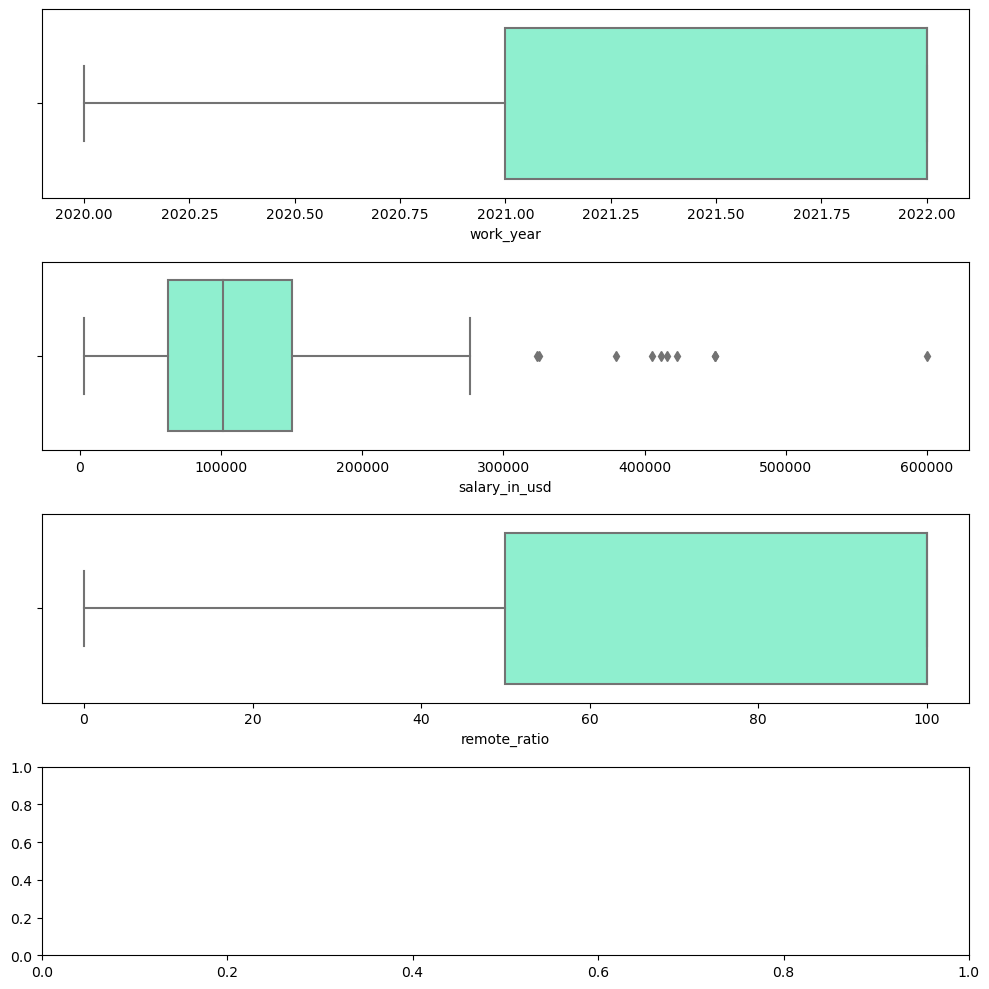

In [38]:
fig, axes = plt.subplots(4, 1, figsize=(10,10))

axes = axes.flat

for indice, columna in enumerate(numericas.columns):
    sns.boxplot(x = numericas[columna], data = numericas, ax=axes[indice], color = "aquamarine"); # para trazar una línea de densidad
  
plt.tight_layout()
plt.show()

Efectivamente, como sospechabamos, tenemos outliers a partir de un poquito menos de 300000 dólares de salario (aproximadamente).

Qué hacemos con estos outliers? Vamos a estudiarlos en dos df separados y averiguamos el por qué de estos outliers, o si simplemente son un error de muestreo. 
Partiremos nuestro df de salarios bajos en 2 por el Q3.

In [39]:
def detectar_outliers(lista_columnas, dataframe): 
    
    # iteramos por la lista de las columnas numéricas de nuestro dataframe
    for col in lista_columnas:
        
        #calculamos los cuartiles Q1 y Q3
        Q1 = np.nanpercentile(df[col], 25)
        Q3 = np.nanpercentile(df[col], 75)
        
        # calculamos el rango intercuartil
        IQR = Q3 - Q1
        
        # calculamos los límites
        outlier_step = 1.5 * IQR
        
        # filtramos nuestro dataframe para indentificar los outliers
        outliers_bajos = dataframe[(dataframe[col] > Q3 + outlier_step)]

    
    return outliers_bajos

In [40]:
salarios_altos = detectar_outliers(['salary_in_usd'],df)
salarios_altos.head(2)

,work_year,experience_level,employment_type,job_title,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
25,2020,Executive Level,Full-Time,Director of Data Science,325000,US,100,US,L
33,2020,Mid-Level,Full-Time,Research Scientist,450000,US,0,US,M


In [41]:
salarios_altos['salary_in_usd'].min()

324000

Hemos creado un DF con los outliers, y sabemos a partir de qué salario lo considera outlier. Vamos a filtrar el df de salarios_bajos para que no contentga outliers

In [42]:
salarios_bajos = df[df['salary_in_usd']< 324000]

In [43]:
salarios_bajos.head(2)

,work_year,experience_level,employment_type,job_title,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2020,Mid-Level,Full-Time,Data Scientist,79833,DE,0,DE,L
1,2020,Senior,Full-Time,Machine Learning Scientist,260000,JP,0,JP,S


Vamos a comparar variables como las de job title, experience, employment type, company location y company size para ver si hay alguna diferencia entre mis dos nuevos subdataframes del salario bajo, para entender el tratamiento de los outliers

In [44]:
salarios_altos.groupby('experience_level').size()

experience_level
Executive Level    4
Mid-Level          3
Senior             3
dtype: int64

In [45]:
salarios_bajos.groupby('experience_level').size()

experience_level
Entry-Level         88
Executive Level     22
Mid-Level          210
Senior             277
dtype: int64

In [46]:
salarios_altos.groupby('job_title').size()

job_title
Applied Data Scientist                1
Applied Machine Learning Scientist    1
Data Analytics Lead                   1
Data Engineer                         1
Data Scientist                        1
Director of Data Science              1
Financial Data Analyst                1
Principal Data Engineer               1
Principal Data Scientist              1
Research Scientist                    1
dtype: int64

In [47]:
salarios_bajos.groupby('job_title').size()

job_title
3D Computer Vision Researcher                 1
AI Scientist                                  7
Analytics Engineer                            4
Applied Data Scientist                        4
Applied Machine Learning Scientist            3
BI Data Analyst                               6
Big Data Architect                            1
Big Data Engineer                             8
Business Data Analyst                         5
Cloud Data Engineer                           2
Computer Vision Engineer                      6
Computer Vision Software Engineer             3
Data Analyst                                 97
Data Analytics Engineer                       4
Data Analytics Manager                        7
Data Architect                               11
Data Engineer                               131
Data Engineering Manager                      5
Data Science Consultant                       7
Data Science Engineer                         3
Data Science Manager          

In [48]:
salarios_altos.groupby('employment_type').size()

employment_type
Contract     1
Full-Time    9
dtype: int64

In [49]:
salarios_bajos.groupby('employment_type').size()

employment_type
Contract       4
Freelance      4
Full-Time    579
Part-Time     10
dtype: int64

In [50]:
salarios_altos.groupby('company_location').size()

company_location
US    10
dtype: int64

In [51]:
salarios_bajos.groupby('company_location').size()

company_location
AE      3
AS      1
AT      4
AU      3
BE      2
BR      3
CA     30
CH      2
CL      1
CN      2
CO      1
CZ      2
DE     28
DK      3
DZ      1
EE      1
ES     14
FR     15
GB     47
GR     11
HN      1
HR      1
HU      1
IE      1
IL      1
IN     24
IQ      1
IR      1
IT      2
JP      6
KE      1
LU      3
MD      1
MT      1
MX      3
MY      1
NG      2
NL      4
NZ      1
PK      3
PL      4
PT      4
RO      1
RU      2
SG      1
SI      2
TR      3
UA      1
US    345
VN      1
dtype: int64

In [52]:
salarios_altos.groupby('company_size').size()

company_size
L    7
M    2
S    1
dtype: int64

In [53]:
salarios_bajos.groupby('company_size').size()

company_size
L    191
M    324
S     82
dtype: int64

Como hemos visto con este análisis, podemos intuir que los outliers se deben a la diferencia entre tamaño de empresa, como un posible factor de variabilidad del precio. De esta manera, decidimos dividir nuestro DF en dos, para estudiarlo en casos separados.

Ahora para nuestras variables categoricas

In [54]:
df.describe(include='object')

,experience_level,employment_type,job_title,employee_residence,company_location,company_size
count,607,607,607,607,607,607
unique,4,4,50,57,50,3
top,Senior,Full-Time,Data Scientist,US,US,M
freq,280,588,143,332,355,326


Podemos ver que la moda es Data Scientist, que se paga en dólares y que residen que USA,y trabajan en empresas medianas. Y que nuestras columnas de experience_level y employment_type hay que hacerle un replace para que sea entendible las etiquetas de las variables.

guardamos los dos data frames en dos archivos distintos:

In [55]:
salarios_bajos.to_csv('../datos/salarios_bajos.csv')

In [56]:
salarios_altos.to_csv('../datos/salarios_altos.csv')